<a href="https://colab.research.google.com/github/dineshnaiduavula/NLP/blob/main/coursework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                 Tweet  \
0    He who exalts himself shall      be humbled; a...   
1    RT @prayerbullets: I remove Nehushtan -previou...   
2    @Brainman365 @heidtjj @BenjaminLives I have so...   
3    #God is utterly powerless without Human interv...   
4    @David_Cameron   Miracles of #Multiculturalism...   
..                                                 ...   
995  So anti-choice laws are telling these women th...   
996  Like how can you sit there and even go through...   
997  Fair IS fair if U believe an unborn child has ...   
998  @MichestBlogSpot: Postinor is popularly  used ...   
999  #FF #Patriot --> PigsWalkUpright.  Thanks 4 fo...   

                       Target   Stance  \
0                     Atheism  AGAINST   
1                     Atheism  AGAINST   
2                     Atheism  AGAINST   
3                     Atheism  AGAINST   
4                     Atheism  AGAINST   
..                        ...      ...   
995  Lega

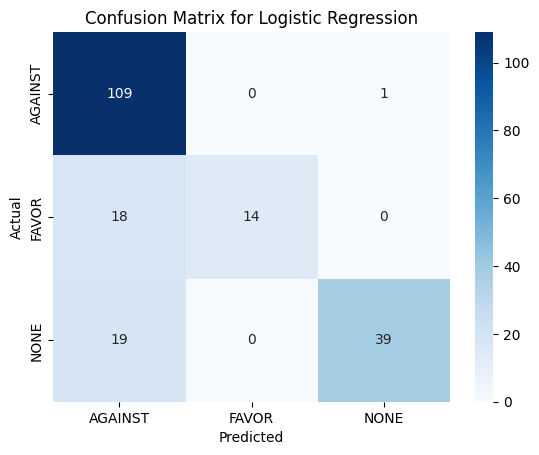

Results for Naïve Bayes:

              precision    recall  f1-score   support

     AGAINST       0.72      0.97      0.83       110
       FAVOR       1.00      0.47      0.64        32
        NONE       0.92      0.59      0.72        58

    accuracy                           0.78       200
   macro avg       0.88      0.68      0.73       200
weighted avg       0.82      0.78      0.77       200



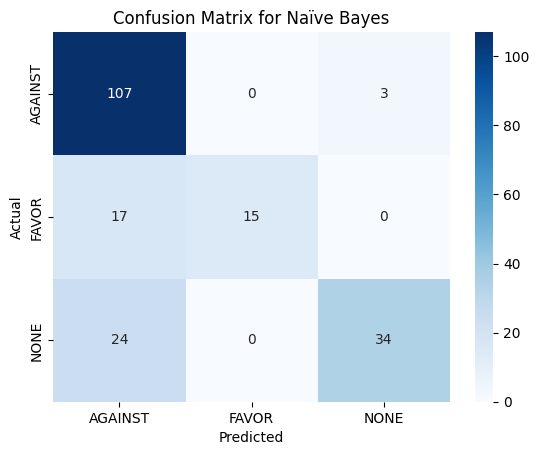

Results for Random Forest:

              precision    recall  f1-score   support

     AGAINST       0.84      0.99      0.91       110
       FAVOR       0.96      0.84      0.90        32
        NONE       1.00      0.74      0.85        58

    accuracy                           0.90       200
   macro avg       0.94      0.86      0.89       200
weighted avg       0.91      0.90      0.89       200



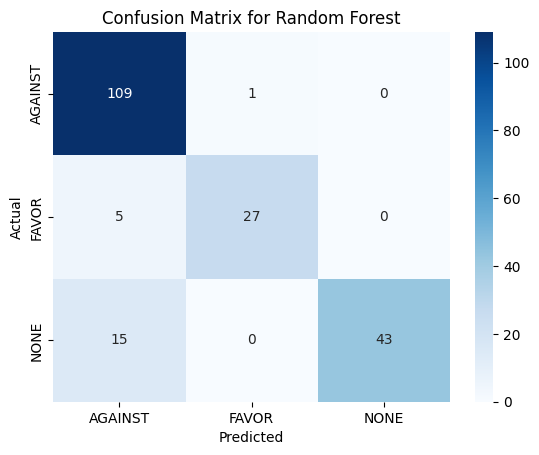

                 Model  Accuracy  Macro F1-Score
0  Logistic Regression     0.810        0.752059
1          Naïve Bayes     0.780        0.727848
2        Random Forest     0.895        0.887873


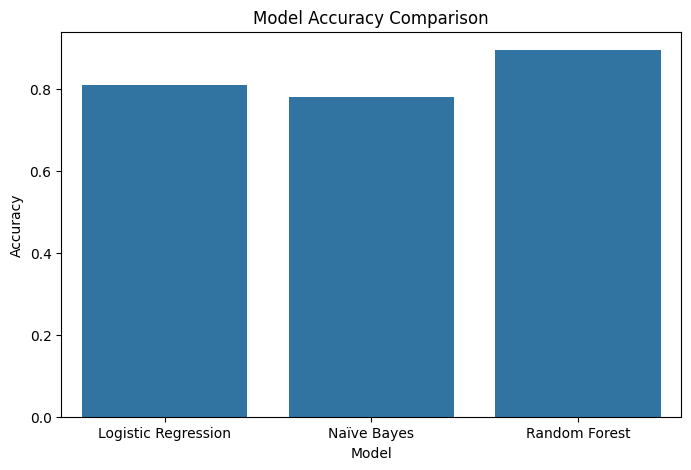

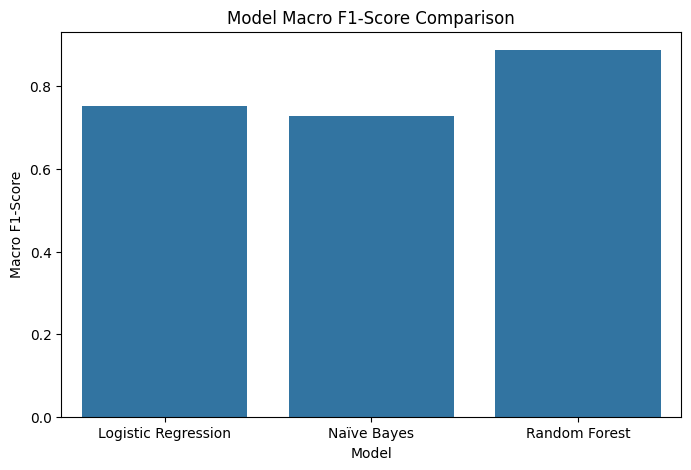

Best model (Random Forest) saved successfully.


In [12]:

# Downloading all the necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

train_url= "https://raw.githubusercontent.com/dineshnaiduavula/NLP/main/train.csv"
test_url= "https://raw.githubusercontent.com/dineshnaiduavula/NLP/main/test.csv"



try:
    test_dset = pd.read_csv(test_url, encoding="ISO-8859-1", nrows=1000)
    print(test_dset)
except Exception as e:
    print("Error reading file:", e)

try:
    train_dset = pd.read_csv(train_url, encoding="ISO-8859-1", nrows=1000)
    print(train_dset)
except Exception as e:
    print("Error reading file:", e)




lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to clean tweets
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and special characters
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return " ".join(tokens)

# Apply cleaning function
train_dset["cleaned_tweet"] = train_dset["Tweet"].apply(clean_text)
test_dset["cleaned_tweet"] = test_dset["Tweet"].apply(clean_text)

print(train_dset[["Tweet", "cleaned_tweet"]].head())  # Check cleaned tweets

print(train_dset.columns)


from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Unigrams & bigrams
X_train = vectorizer.fit_transform(train_dset["cleaned_tweet"])
X_test = vectorizer.transform(test_dset["cleaned_tweet"])

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_dset["Stance"])

print("Labels:", label_encoder.classes_)  # Check encoded labels


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split training data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train models
for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    print(f"{name} trained successfully.")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_val_split)
    print(f"Results for {name}:\n")
    print(classification_report(y_val_split, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_val_split, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
from sklearn.metrics import accuracy_score, f1_score

# Store results
results = {
    "Model": [],
    "Accuracy": [],
    "Macro F1-Score": []
}

for name, model in models.items():
    y_pred = model.predict(X_val_split)
    acc = accuracy_score(y_val_split, y_pred)
    f1 = f1_score(y_val_split, y_pred, average='macro')

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Macro F1-Score"].append(f1)

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Plot results
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=df_results)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Macro F1-Score", data=df_results)
plt.title("Model Macro F1-Score Comparison")
plt.ylabel("Macro F1-Score")
plt.show()

import joblib

# Save the best model
best_model_name = df_results.sort_values(by="Accuracy", ascending=False)["Model"].iloc[0]
best_model = models[best_model_name]
joblib.dump(best_model, "best_stance_model.pkl")
print(f"Best model ({best_model_name}) saved successfully.")

# Make predictions on test set
y_test_pred = best_model.predict(X_test)

# Convert predictions back to labels
y_test_labels = label_encoder.inverse_transform(y_test_pred)
